In this case, we had masks created with cellpose. The masks were divided in two types: one type contained individual organelles. The other mask contain the cells (each cell can have up to 6 organelles). In this notebook, we're selecting only the masks with invidual organelles. Sometimes, in other notebooks, we use the cell mask to cut the set of organelles per cell. 

In [1]:
# Import required packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from skimage.measure import label, regionprops, regionprops_table
from scipy.stats import gaussian_kde, ks_2samp
import torch
from pathlib import Path
from tqdm import tqdm
import atomai as aoi

In [2]:
# Some helper functions
def make_square(img,box_size):
  y = (box_size - img.shape[0])
  if y%2==0:
    y1=y2=y/2
  else:
    y1 = np.ceil(y/2)
    y2 = y - y1
  x = (box_size - img.shape[1])
  if x%2==0:
    x1=x2=x/2
  else:
    x1 = np.ceil(x/2)
    x2 = x - x1
  
  return np.pad(img,((int(y1),int(y2)),(int(x1),int(x2))),mode='constant',constant_values=0)
  
def normalize_01(inp: np.ndarray):
    """
    normalize image range from 0 to 1
    """
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def rotate_and_pad_img(sample,pixels,box_size,rotate=False):
    """
    Function to crop, rotate, and pad a labelled section of a segmented image
    Args:
      sample (label)
      Sample from labelled image

      pixels (array)
      image array, H x W, single-channel
      
      box_size (int)
      Size of final square image dimension
    Returns square-padded image array
    """
    angle = np.degrees(sample.orientation)
    length = sample.major_axis_length
    width = sample.minor_axis_length
    target_channel = pixels[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
    target_channel = (target_channel > 0) * sample.filled_image
    if rotate == True:
      rotated_image = sk.transform.rotate(target_channel, -angle-90, resize = True)
      H, W = rotated_image.shape
      image_center = rotated_image[max([int(H/2-width/2), 0]):int(H/2+width/2)+1,max([0,int(W/2-length/2)]):int(W/2+length/2)]
      return make_square(np.ones(sample.filled_image.shape)*(image_center),box_size)
    else:
      return make_square(np.ones(sample.filled_image.shape)*(target_channel),box_size)

def mask2stack(ccm_mask,cell_mask=None,window_size=115,rotate=False):
  """
  Function to ingest cell mask and carboxysome mask or pixel intensity and output an array of padded submasks
  Args:
  cell_mask (labelled image)
  
  ccm_mask (labelled image or pixel intensity array)

  window_size (int)
  Size of padded image
  """

  if cell_mask.any:
    labelled_image = label(cell_mask)
    feature_table = regionprops(labelled_image)
    CellSize_label = []
        # remove debris
    for i in feature_table:
        if (i.area) > 40 and (i.major_axis_length/i.minor_axis_length) > 2:
                CellSize_label.append(i.label)
    subimgs = []
    for i in np.argsort(CellSize_label):
        sample = feature_table[CellSize_label[i]-1]
        cell = rotate_and_pad_img(sample,cell_mask,window_size,rotate)
        ccm = rotate_and_pad_img(sample,ccm_mask,window_size,rotate)
        #ccm = np.ones(ccm.shape) * (ccm >0.01)
        subimgs.append(ccm)
  else:
    labelled_image = label(ccm_mask)
    feature_table = regionprops(labelled_image)
    subimgs = [make_square(np.ones(sample.filled_image.shape) * sample.filled_image,window_size) for sample in feature_table]
  return np.stack(subimgs,axis=0)

In [3]:
if os.path.exists(r'../data/subimg.npy'):
    subimg = np.load(r'../data/subimg.npy')
else:
    directory = r'../data'
    files = Path(directory).rglob('*.czi')
    mask_stack = list()
    for f in tqdm(list(files)):
        cell_mask = np.load(str(f)[0:-4] + '_cell.npy')
        ccm_mask = np.load(str(f)[0:-4] + '_ccm.npy')
        mask_stack.append(mask2stack(ccm_mask,cell_mask,rotate=False))
    subimg = np.vstack(mask_stack)
    np.save(r'../data/subimg.npy',subimg)
subimg.shape

(62284, 115, 115)

**Plotting some of the subimages**

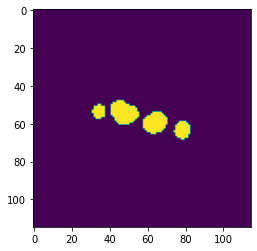

In [4]:
plt.imshow(subimg[4000,:,:])

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='GeForce GTX 1660 Ti', major=7, minor=5, total_memory=6144MB, multi_processor_count=24)

**rVAE**

In [7]:
in_dim = (subimg.shape[1], subimg.shape[2])
depth = 256
batch = 10



rvae = aoi.models.rVAE(in_dim, translation= True,
                        numlayers_encoder=3, numhidden_encoder=depth,
                        numlayers_decoder=3, numhidden_decoder=depth,
                        Skip = True)

rvae.fit(subimg,training_cycles=100, batch_size=batch)

Epoch: 1/100, Training loss: 116.8438
Epoch: 2/100, Training loss: 89.8819
Epoch: 3/100, Training loss: 84.1467
Epoch: 4/100, Training loss: 81.8300
Epoch: 5/100, Training loss: 80.5897
Epoch: 6/100, Training loss: 79.6071
Epoch: 7/100, Training loss: 78.9296
Epoch: 8/100, Training loss: 78.2878
Epoch: 9/100, Training loss: 77.8665
Epoch: 10/100, Training loss: 77.2734
Epoch: 11/100, Training loss: 76.9303
Epoch: 12/100, Training loss: 76.5930
Epoch: 13/100, Training loss: 76.6005
Epoch: 14/100, Training loss: 76.6225


KeyboardInterrupt: 

In [4]:
#rvae.save_model("cell-rvae-iter100-control-and-induced-4-8-24-48-72")
#rvae.save_weights("cell-w-rvae-iter100-control-and-induced-4-8-24-48-72")
rvae= aoi.models.load_model("cell-rvae-iter100-control-and-induced-4-8-24-48-72.tar")

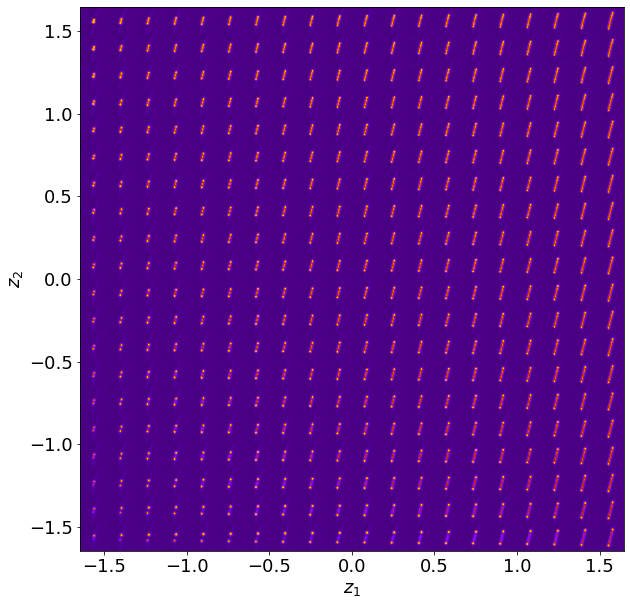

array([[0.08964232, 0.08963954, 0.08963501, ..., 0.09150382, 0.09142247,
        0.09134036],
       [0.08964708, 0.08964527, 0.08964183, ..., 0.09123164, 0.09115669,
        0.09108601],
       [0.08965126, 0.0896503 , 0.08964794, ..., 0.09100194, 0.09094401,
        0.09089104],
       ...,
       [0.09000772, 0.09000226, 0.08999567, ..., 0.09202787, 0.09201973,
        0.09201244],
       [0.08999856, 0.08999164, 0.08998384, ..., 0.09202509, 0.09201635,
        0.09200869],
       [0.08998755, 0.08997954, 0.08997061, ..., 0.09202314, 0.09201421,
        0.09200614]])

In [6]:
rvae.manifold2d(d=20)





In [7]:
directory = r'../data'
files = Path(directory).rglob('*.czi')
mask_stack = list()
Timepoints = list()
Induction = list()
stacks = [list() for i in range(10)]
for f in tqdm(list(files)):
    if 'Control' in str(f):
        IPTG = 0
    elif 'Induced' in str(f):
        IPTG = 1
    else:
        print('no folder?')
    folder = os.path.basename(os.path.dirname(f))
    Time = int(folder)
    cell_mask = np.load(str(f)[0:-4] + '_cell.npy')
    ccm_mask = np.load(str(f)[0:-4] + '_ccm.npy')
    if IPTG == 0 and Time == 4:
        imgset = 0
    elif IPTG == 0 and Time == 8:
        imgset = 1
    elif IPTG == 0 and Time == 24:
        imgset = 2
    elif IPTG == 0 and Time == 48:
        imgset = 3
    elif IPTG == 0 and Time == 72:
        imgset = 4
    elif IPTG == 1 and Time == 4:
        imgset = 5
    elif IPTG == 1 and Time == 8:
        imgset = 6
    elif IPTG == 1 and Time == 24:
        imgset = 7
    elif IPTG == 1 and Time == 48:
        imgset = 8
    elif IPTG == 1 and Time == 72:
        imgset = 9
    stacks[imgset].append(mask2stack(ccm_mask,cell_mask,rotate=False))
subimgs = [np.vstack(x) for x in stacks]
results = [rvae.encode(x) for x in subimgs]

100%|██████████| 96/96 [01:23<00:00,  1.15it/s]


In [8]:
titles = ['Control 4','Control 8','Control 24','Control 48','Control 72','Induced 4','Induced 8','Induced 24','Induced 48','Induced 72']
params = ['Angle','x shift','y shift','L1','L2']

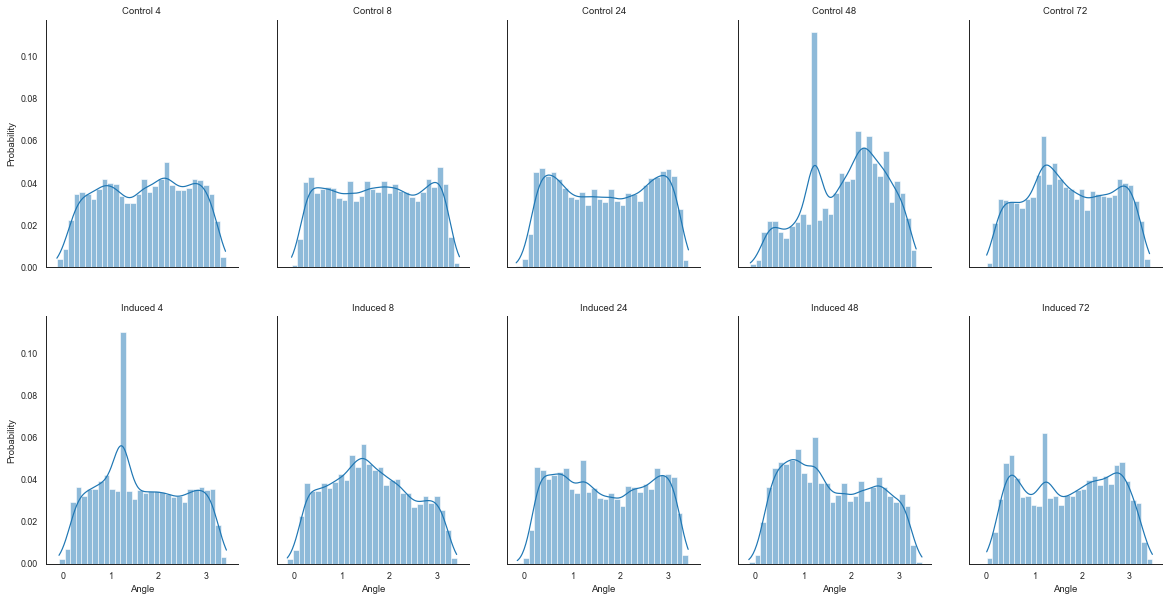

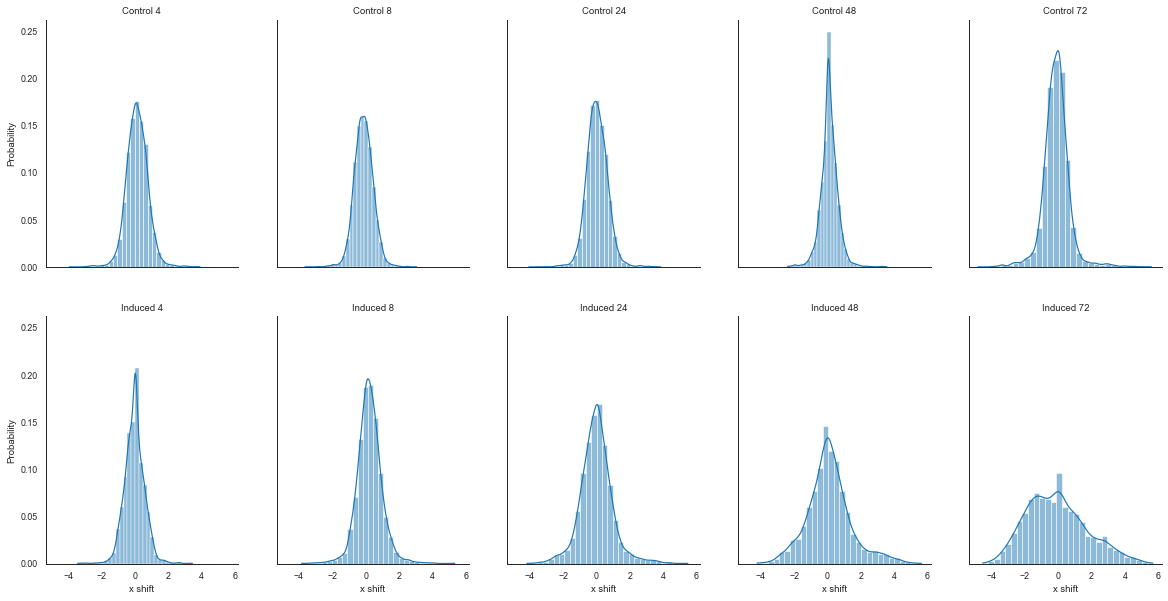

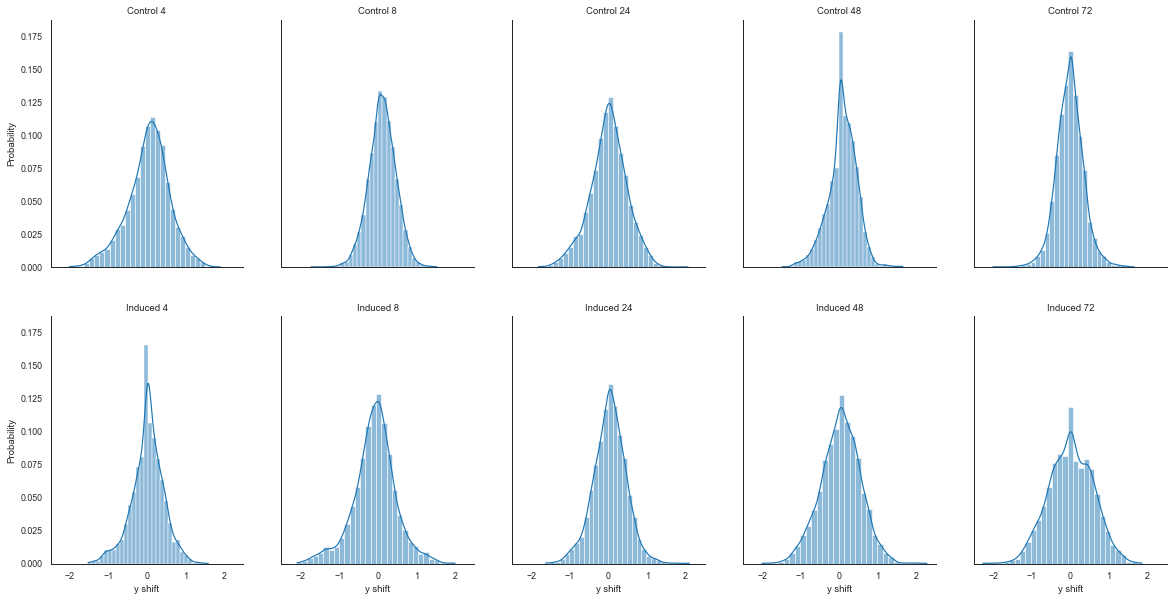

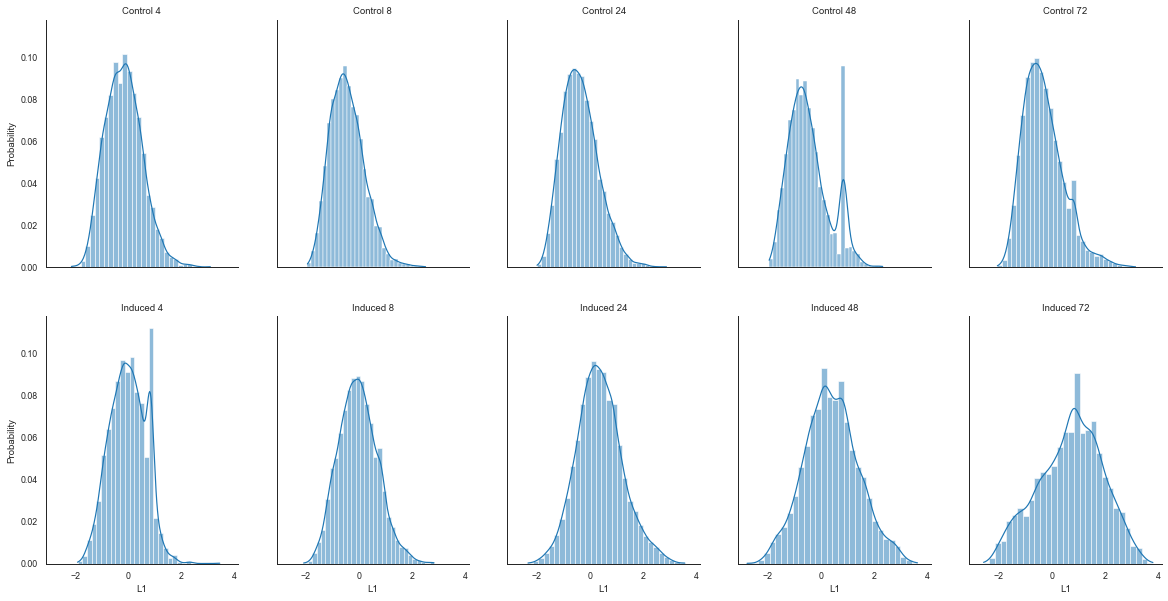

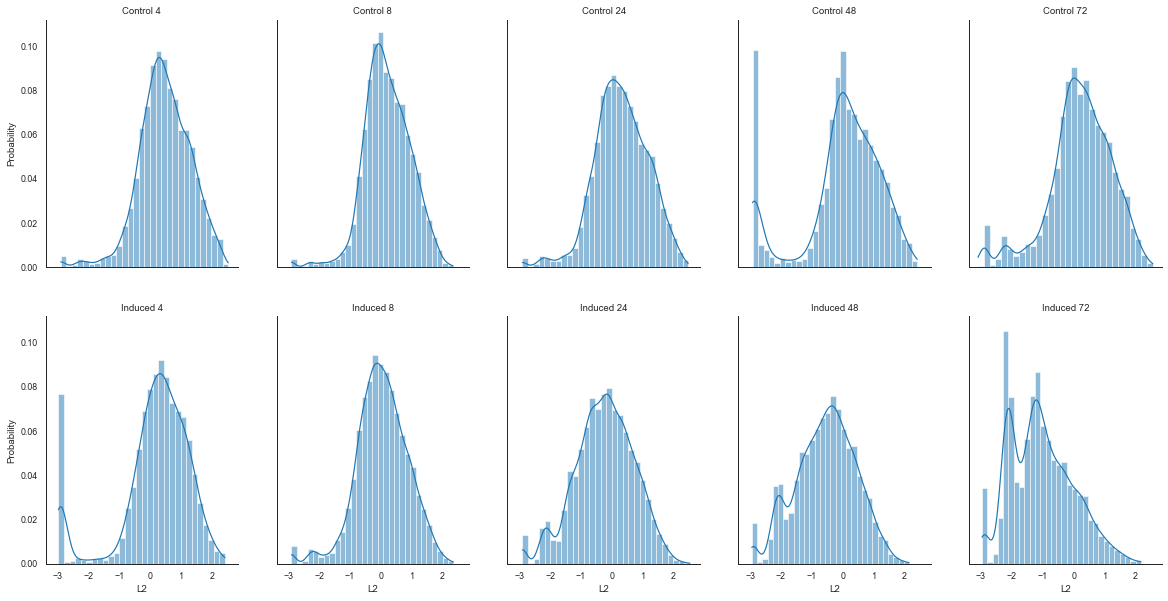

In [9]:
sns.set_context('paper')
sns.set_style('white')
for i,param in enumerate(params):
    f, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(20, 10))
    for j, ax in zip(range(10),axes.ravel()):
        sns.histplot(results[j][0][:,i],bins=30,stat='probability',kde=True,ax=ax)
        ax.set_title(titles[j])
        ax.set_xlabel(param)
    sns.despine()

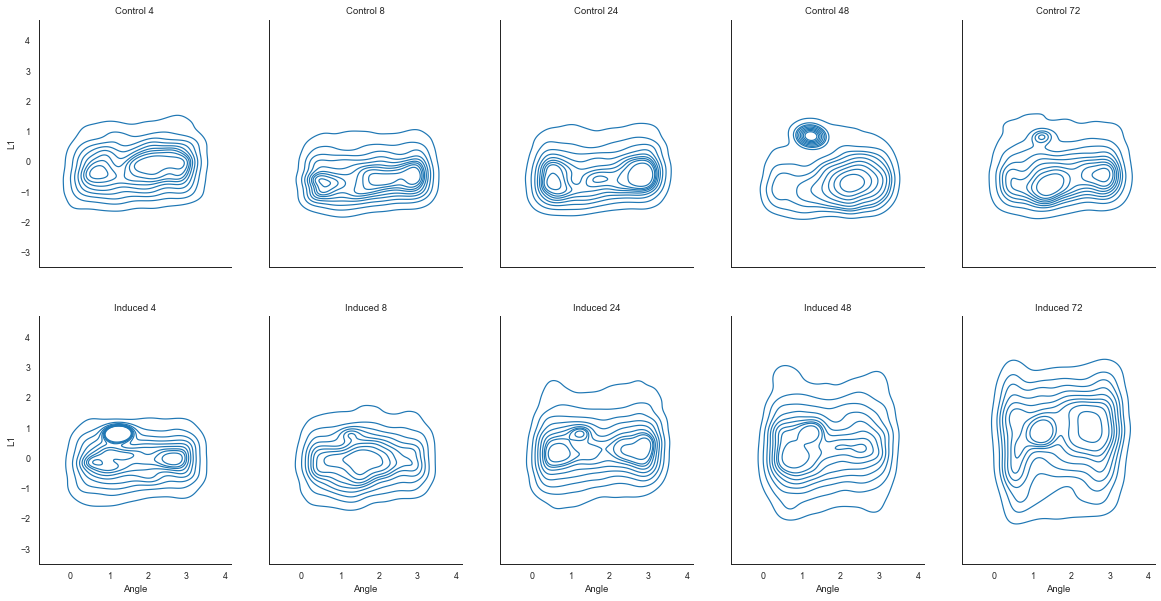

In [10]:
sns.set_context('paper')
sns.set_style('white')

f, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(20, 10))
for j, ax in zip(range(10),axes.ravel()):
    sns.kdeplot(x=results[j][0][:,0],y=results[j][0][:,3],ax=ax)
    ax.set_title(titles[j])
    ax.set_xlabel('Angle')
    ax.set_ylabel('L1')
sns.despine()

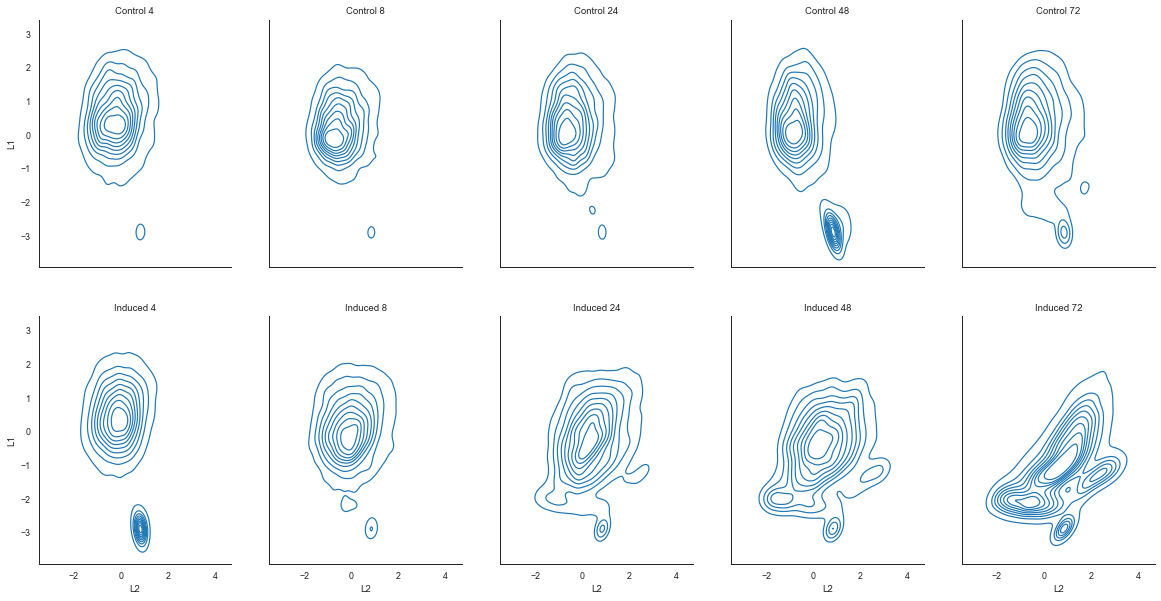

In [11]:
sns.set_context('paper')
sns.set_style('white')

f, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(20, 10))
for j, ax in zip(range(10),axes.ravel()):
    sns.kdeplot(x=results[j][0][:,3],y=results[j][0][:,4],ax=ax)
    ax.set_title(titles[j])
    ax.set_xlabel('L2')
    ax.set_ylabel('L1')
sns.despine()

# Conduct Two-sample Kolmogorov–Smirnov test

In [13]:
alpha = 0.01
df = pd.DataFrame(columns=['Time','Latent parameter','D_crit','Alpha','D','p','Significance'])
timepoints=[4,8,24,48,72]
for i,param in enumerate(params):
    for j in range(5):
        D = np.sqrt(-np.log(alpha/2)*((1+(len(results[j][0][:,i])/len(results[j+5][0][:,i])))/(2*len(results[j+5][0][:,i]))))     
        ks ,p = ks_2samp(results[j][0][:,i],results[j+5][0][:,i])
        if ks > D and p < alpha:
            significance = 'Significant'
        else:
            significance = 'ns'
        df = df.append(pd.DataFrame([[timepoints[j],param,D,alpha,ks,p,significance]],columns=['Time','Latent parameter','D_crit','Alpha','D','p','Significance']),ignore_index=True)

df


,Time,Latent parameter,D_crit,Alpha,D,p,Significance
0,4,Angle,0.036182,0.01,0.073760,1.487300e-10,Significant
1,8,Angle,0.026768,0.01,0.083678,4.440892e-16,Significant
2,24,Angle,0.021144,0.01,0.019866,6.126579e-02,ns
3,48,Angle,0.024465,0.01,0.208420,3.774758e-15,Significant
4,72,Angle,0.038070,0.01,0.041842,1.640893e-04,Significant
5,4,x shift,0.036182,0.01,0.150588,6.661338e-16,Significant
6,8,x shift,0.026768,0.01,0.234939,7.822670e-07,Significant
7,24,x shift,0.021144,0.01,0.101618,5.326925e-40,Significant
8,48,x shift,0.024465,0.01,0.203697,3.774758e-15,Significant
9,72,x shift,0.038070,0.01,0.265796,2.223407e-167,Significant


1.7 -2.0
1.7 0.0
1.7 2.0
2.0 -2.0
0.0 1.0
0.0 2.0
0.0 2.5


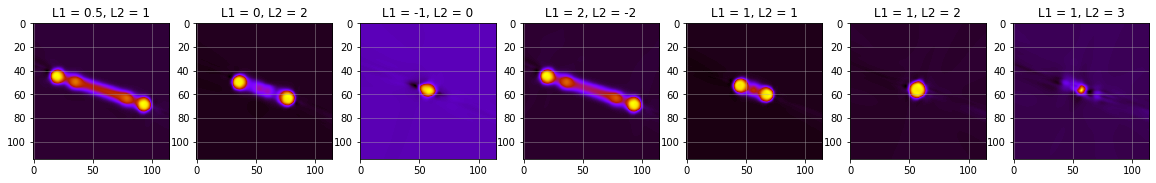

In [ ]:
# L1 = 1.7
# L2 = -2
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = -1
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = 0
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 0 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded3 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = 1
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = 1
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,7,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = 0.5, L2 = 1')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,7,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = 2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,7,3)
ax.imshow(decoded3[0], cmap="gnuplot")
ax.set_title('L1 = -1, L2 = 0')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)




0.014559389


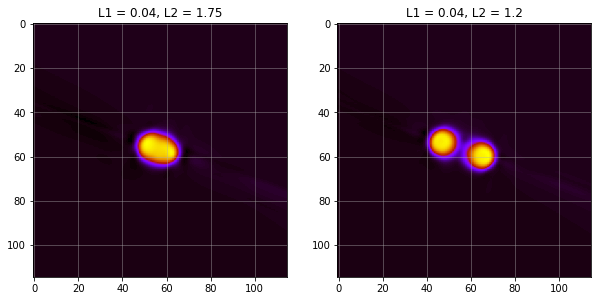

In [ ]:
# L1 = 0
lv1_vals = a72c[:,3][(a72c[:,3] > 0.001) & (a72c[:,3] < 0.05)]

# L2 = 1.75
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1.75 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)

# L2 = 1.2
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1.2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
# print("2",lv_vals)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,2,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = 0.04, L2 = 1.75')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,2,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = 0.04, L2 = 1.2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

print(lv1_vals[0])

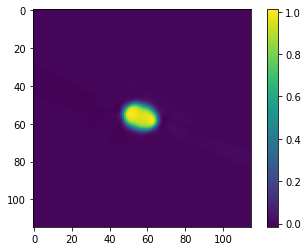

In [ ]:
plt.imshow(decoded1[0])
plt.colorbar()

In [ ]:
atotal, btotal = rvae.encode(subimg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':


(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 9 Text major ticklabel objects>)

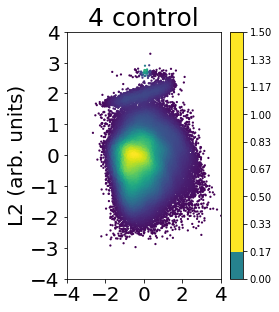

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
x = atotal[:,3]
y = atotal[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L2 (arb. units)',fontsize=20)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

5 -0.00022782385 0.0
5 -0.00022782385 0.0
241 -2.0194826 0.0


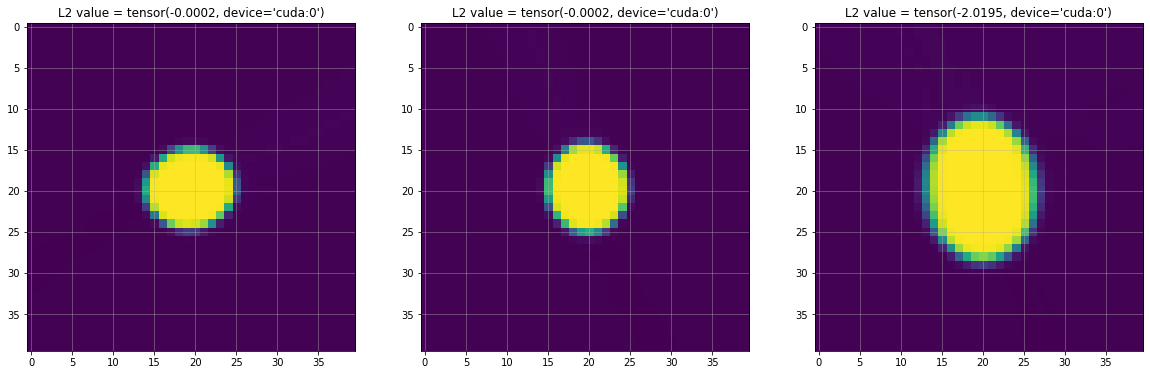

In [ ]:
import torch


#Fixing l1, and varying l2 and the angle
# l2 = 0, angle = -3
alpha = -3  
lv2_vals = a72i[:,4][(a72i[:,4] > -0.001) & (a72i[:,4] < 0)]
lv1_vals = np.zeros_like(lv2_vals) + 0

#Fixing L1 to zero and changing L2 and angle
arr_size = lv2_vals.size
print(arr_size,lv2_vals[0],lv1_vals[0])

device = rvae.device  # to ensure that our arrays are on the same device as model weights
grid = rvae.x_coord.expand(arr_size, *rvae.x_coord.size()).to(device)  # coordinate grid

# angle to rotate (if keeping it constant)
# alpha = -3  
a = (torch.ones(size=(arr_size,)) * alpha).to(device)
l2_1 = torch.from_numpy(lv2_vals).to(device)
l1_1 = torch.from_numpy(lv1_vals).to(device)

# Prepare inputs into the decoder
z = torch.cat((l1_1[:, None], l2_1[:, None]), dim=-1)
grid_ = aoi.utils.transform_coordinates(grid, a, 0)

# Decode
with torch.no_grad():
    decoded1 = rvae.decoder_net(grid_, z).cpu()


# l2 = 0, angle = -1.5
alpha = -1.5
lv2_vals = a72i[:,4][(a72i[:,4] > -0.001) & (a72i[:,4] < 0)]
lv1_vals = np.zeros_like(lv2_vals) + 0

#Fixing L1 to zero and changing L2 and angle
arr_size = lv2_vals.size
print(arr_size,lv2_vals[0],lv1_vals[0])

device = rvae.device  # to ensure that our arrays are on the same device as model weights
grid = rvae.x_coord.expand(arr_size, *rvae.x_coord.size()).to(device)  # coordinate grid

# angle to rotate (if keeping it constant) 
a = (torch.ones(size=(arr_size,)) * alpha).to(device)
l2_2 = torch.from_numpy(lv2_vals).to(device)
l1_2 = torch.from_numpy(lv1_vals).to(device)

# Prepare inputs into the decoder
z = torch.cat((l1_2[:, None], l2_2[:, None]), dim=-1)
grid_ = aoi.utils.transform_coordinates(grid, a, 0)

# Decode
with torch.no_grad():
    decoded2 = rvae.decoder_net(grid_, z).cpu()

# l2 = -2, angle = -1.5
alpha = -1.5  
lv2_vals = a72i[:,4][(a72i[:,4] > -2.1) & (a72i[:,4] < -2)]
lv1_vals = np.zeros_like(lv2_vals) + 0

#Fixing L1 to zero and changing L2 and angle
arr_size = lv2_vals.size
print(arr_size,lv2_vals[0],lv1_vals[0])


device = rvae.device  # to ensure that our arrays are on the same device as model weights
grid = rvae.x_coord.expand(arr_size, *rvae.x_coord.size()).to(device)  # coordinate grid

# angle to rotate (if keeping it constant)
# alpha = -3  
a = (torch.ones(size=(arr_size,)) * alpha).to(device)
l2_3 = torch.from_numpy(lv2_vals).to(device)
l1_3 = torch.from_numpy(lv1_vals).to(device)

# Prepare inputs into the decoder
z = torch.cat((l1_3[:, None], l2_3[:, None]), dim=-1)
grid_ = aoi.utils.transform_coordinates(grid, a, 0)

# Decode
with torch.no_grad():
    decoded3 = rvae.decoder_net(grid_, z).cpu()

fig = plt.figure( figsize=(20, 10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(decoded1[0])
ax.set_title('L2 value = ' + str(l2_1[0]))
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1, 3, 2)
ax.imshow(decoded2[0])
ax.set_title('L2 value = ' + str(l2_2[0]))
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1, 3, 3)
ax.imshow(decoded3[0])
ax.set_title('L2 value = ' + str(l2_3[0]))
ax.grid(alpha = 0.5)
plt.savefig('angle-decoded-72induced')
